In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-19 14:24:34.110478: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 14:24:35.243644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 14:24:35.243747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 14:24:35.243813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 14:24:35.739966: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def train_val_generators(TEST_DIR):
  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=256,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

  return test_generator

In [5]:
test_dir = 'pisang/pisang_artificial_ripen/Train'

In [6]:
# Test generators
test_generator = train_val_generators(test_dir)

Found 8033 images belonging to 12 classes.


In [7]:
class_labels = list(test_generator.class_indices.keys())

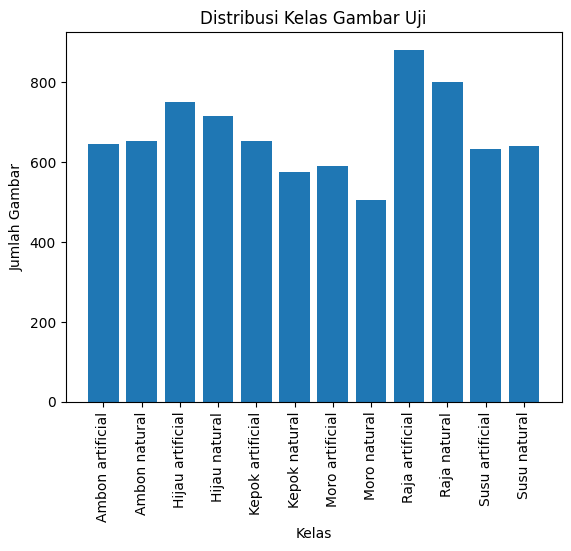

In [7]:
# Menghitung jumlah data per kelas
num_classes_test = len(test_generator.class_indices)
class_counts_test = np.zeros(num_classes_test)

for i in range(len(test_generator)):
    batch_labels_test = np.argmax(test_generator[i][1], axis=1)
    class_counts_test += np.bincount(batch_labels_test, minlength=num_classes_test)

# Mendapatkan nama kelas
class_names_test = list(test_generator.class_indices.keys())

plt.bar(class_names_test, class_counts_test)
plt.title('Distribusi Kelas Gambar Uji')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

# Demo (SGD, Reduce Learning Rate)

In [8]:
model_resnet = 'models/resnet-sgd-no-modif-0,1-0,0001.h5'
model_mobile = 'models/mobile-sgd-no-modif-0,1-0,0001.h5'

## Load Models

In [9]:
from tensorflow import keras
# Generate predictions for the test data
modelRes = keras.models.load_model(model_resnet)

2024-01-16 08:20:24.413933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22142 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


In [10]:
modelMob = keras.models.load_model(model_mobile)

## Test sets

In [11]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [12]:
x1, y1 = test_generator.next()
print("x: ",len(x1)," y: ",len(y1))

x:  256  y:  256


In [13]:
x2, y2 = test_generator.next()
print("x: ",len(x2)," y: ",len(y2))

x:  256  y:  256


## ResNet152 Testing

In [23]:
predResnet = modelRes.predict(x2)

8/8 [==============================] - 1s 85ms/step


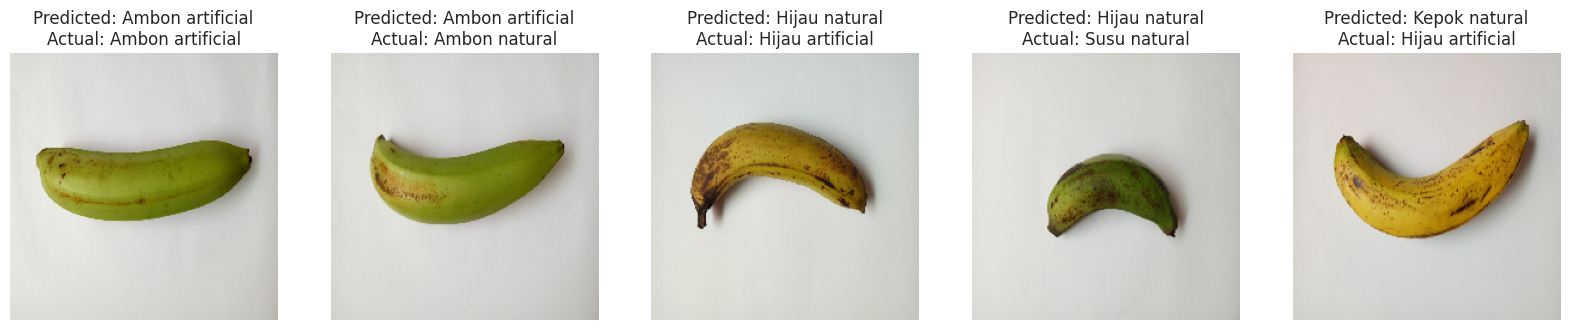

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_generator' and 'ensemble_predictions' are already defined

# Get the first few images and their labels from the test generator
num_images = 5  # Number of images you want to display
test_images, test_labels = next(test_generator)

# Get predictions for these images
predictions = np.argmax(predResnet[:num_images], axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Reverse the dictionary to map indices to class names
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Plotting
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.axis('off')
    # Actual label
    actual_label = index_to_class[np.argmax(test_labels[i])]
    # Predicted label
    pred_label = class_labels[predictions[i]]
    ax.set_title(f"Predicted: {pred_label}\nActual: {actual_label}")

plt.show()


In [24]:
y2_pred = []
for i in y2:
    y2_pred.append(np.argmax(i))

y2_test = []
for i in predResnet:
    y2_test.append(np.argmax(i))

## ResNet152 Evaluation

In [25]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y2_pred, y2_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.92578125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

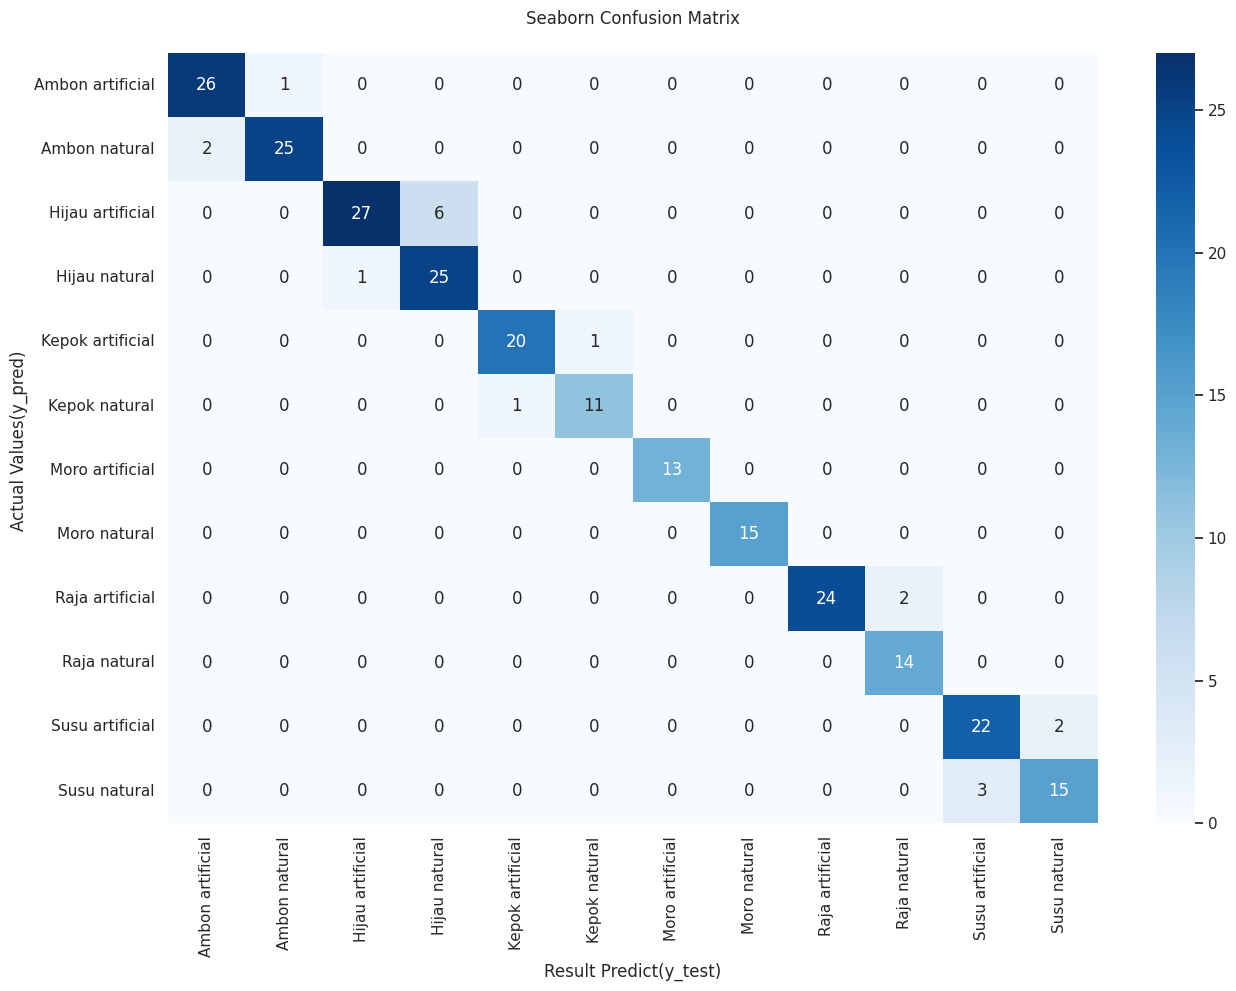

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_resnet = confusion_matrix(y2_test, y2_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_resnet = sns.heatmap(cf_matrix_resnet, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_resnet.set_title('Seaborn Confusion Matrix\n')
ax_resnet.set_xlabel('Result Predict(y_test)')
ax_resnet.set_ylabel('Actual Values(y_pred) ')

In [27]:
from sklearn.metrics import classification_report

report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       0.96      0.93      0.94        27
           2       0.96      0.82      0.89        33
           3       0.81      0.96      0.88        26
           4       0.95      0.95      0.95        21
           5       0.92      0.92      0.92        12
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        15
           8       1.00      0.92      0.96        26
           9       0.88      1.00      0.93        14
          10       0.88      0.92      0.90        24
          11       0.88      0.83      0.86        18

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



## MobileNetV3-small Testing

In [21]:
predMobile = modelMob.predict(x1)

8/8 [==============================] - 0s 18ms/step


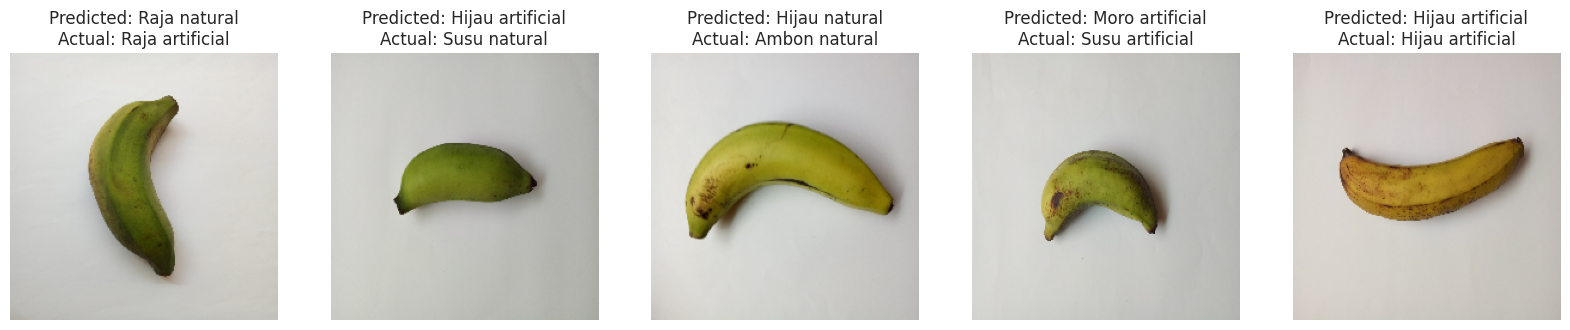

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_generator' and 'ensemble_predictions' are already defined

# Get the first few images and their labels from the test generator
num_images = 5  # Number of images you want to display
test_images, test_labels = next(test_generator)

# Get predictions for these images
predictions = np.argmax(predMobile[:num_images], axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Reverse the dictionary to map indices to class names
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Plotting
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.axis('off')
    # Actual label
    actual_label = index_to_class[np.argmax(test_labels[i])]
    # Predicted label
    pred_label = class_labels[predictions[i]]
    ax.set_title(f"Predicted: {pred_label}\nActual: {actual_label}")

plt.show()


In [22]:
y1_pred = []
for i in y1:
    y1_pred.append(np.argmax(i))

y1_test = []
for i in predMobile:
    y1_test.append(np.argmax(i))

## MobileNetV3-small Evaluation

In [28]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
mobilenet_accuracy = accuracy_score(y1_pred, y1_test)
print("MobileNet Accuracy:", mobilenet_accuracy)

MobileNet Accuracy: 0.8828125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

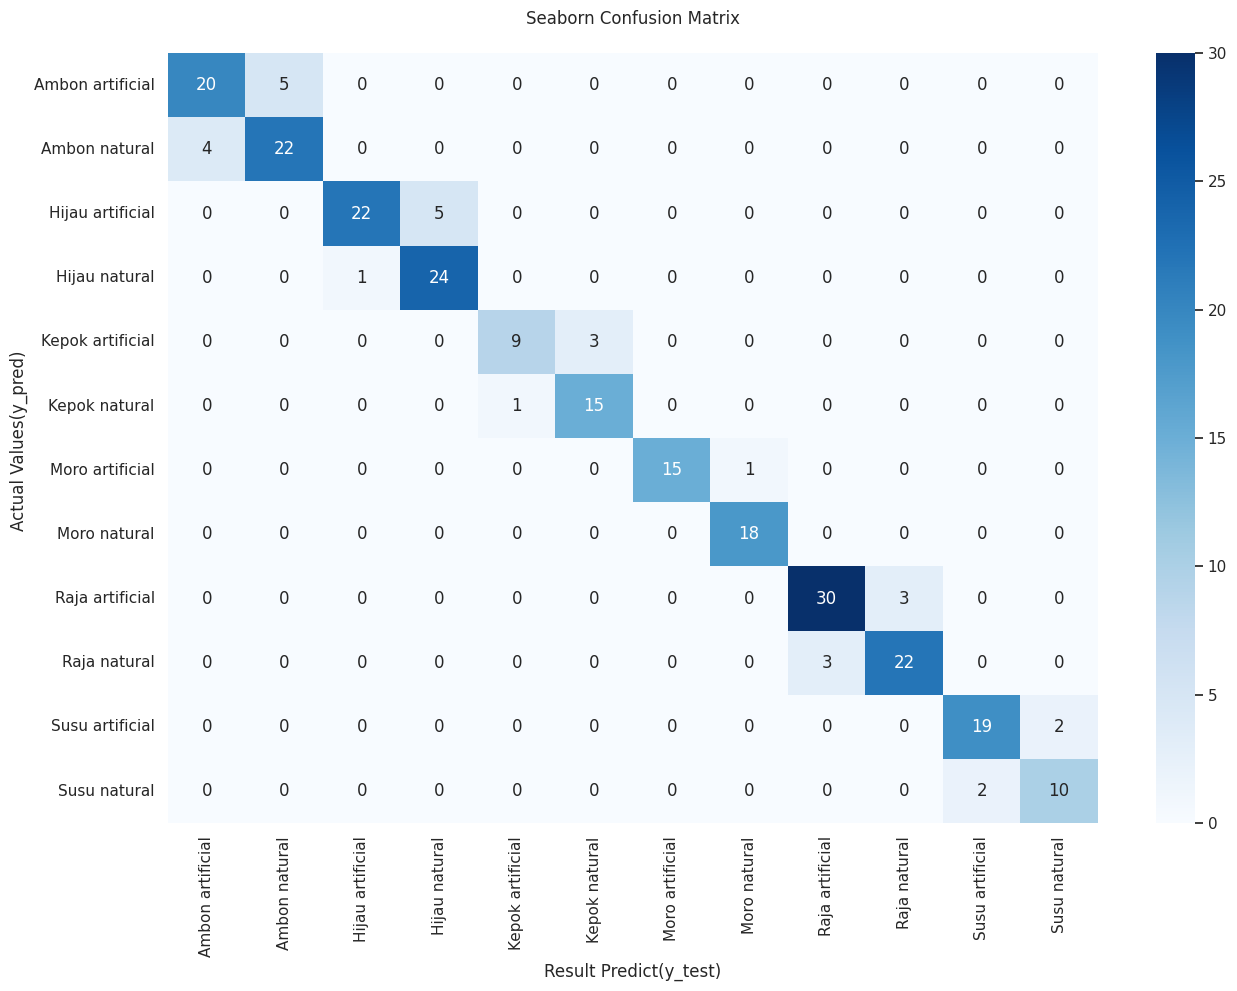

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y1_test, y1_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

In [30]:
from sklearn.metrics import classification_report

report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.81      0.85      0.83        26
           2       0.96      0.81      0.88        27
           3       0.83      0.96      0.89        25
           4       0.90      0.75      0.82        12
           5       0.83      0.94      0.88        16
           6       1.00      0.94      0.97        16
           7       0.95      1.00      0.97        18
           8       0.91      0.91      0.91        33
           9       0.88      0.88      0.88        25
          10       0.90      0.90      0.90        21
          11       0.83      0.83      0.83        12

    accuracy                           0.88       256
   macro avg       0.89      0.88      0.88       256
weighted avg       0.89      0.88      0.88       256



## Ensemble Averaging Testing

In [14]:
pred1 = modelMob.predict(x)

2024-01-12 15:32:34.339442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-12 15:32:35.462452: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 15:32:36.790448: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 10s 19ms/step


In [15]:
pred2 = modelRes.predict(x)

8/8 [==============================] - 3s 79ms/step


In [16]:
ensemble_resmob = (pred1+pred2)/2.0

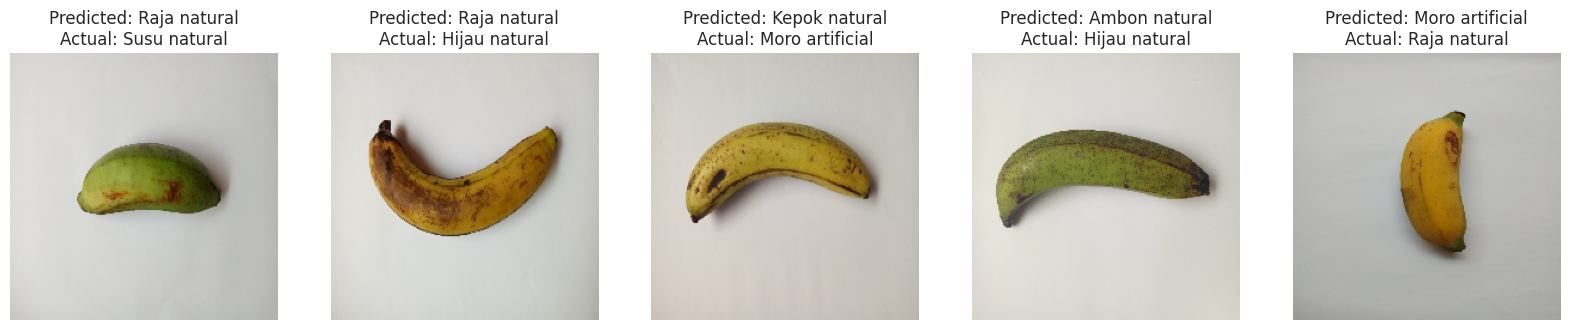

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first few images and their labels from the test generator
num_images = 5  # Number of images you want to display
test_images, test_labels = next(test_generator)

# Get predictions for these images
predictions = np.argmax(ensemble_resmob[:num_images], axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Reverse the dictionary to map indices to class names
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Plotting
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.axis('off')
    # Actual label
    actual_label = index_to_class[np.argmax(test_labels[i])]
    # Predicted label
    pred_label = class_labels[predictions[i]]
    ax.set_title(f"Predicted: {pred_label}\nActual: {actual_label}")

plt.show()

In [20]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in ensemble_resmob:
    y_test.append(np.argmax(i))

## Ensemble Averaging Evaluation

In [31]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
ensemble_accuracy = accuracy_score(y_pred, y_test)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.91015625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

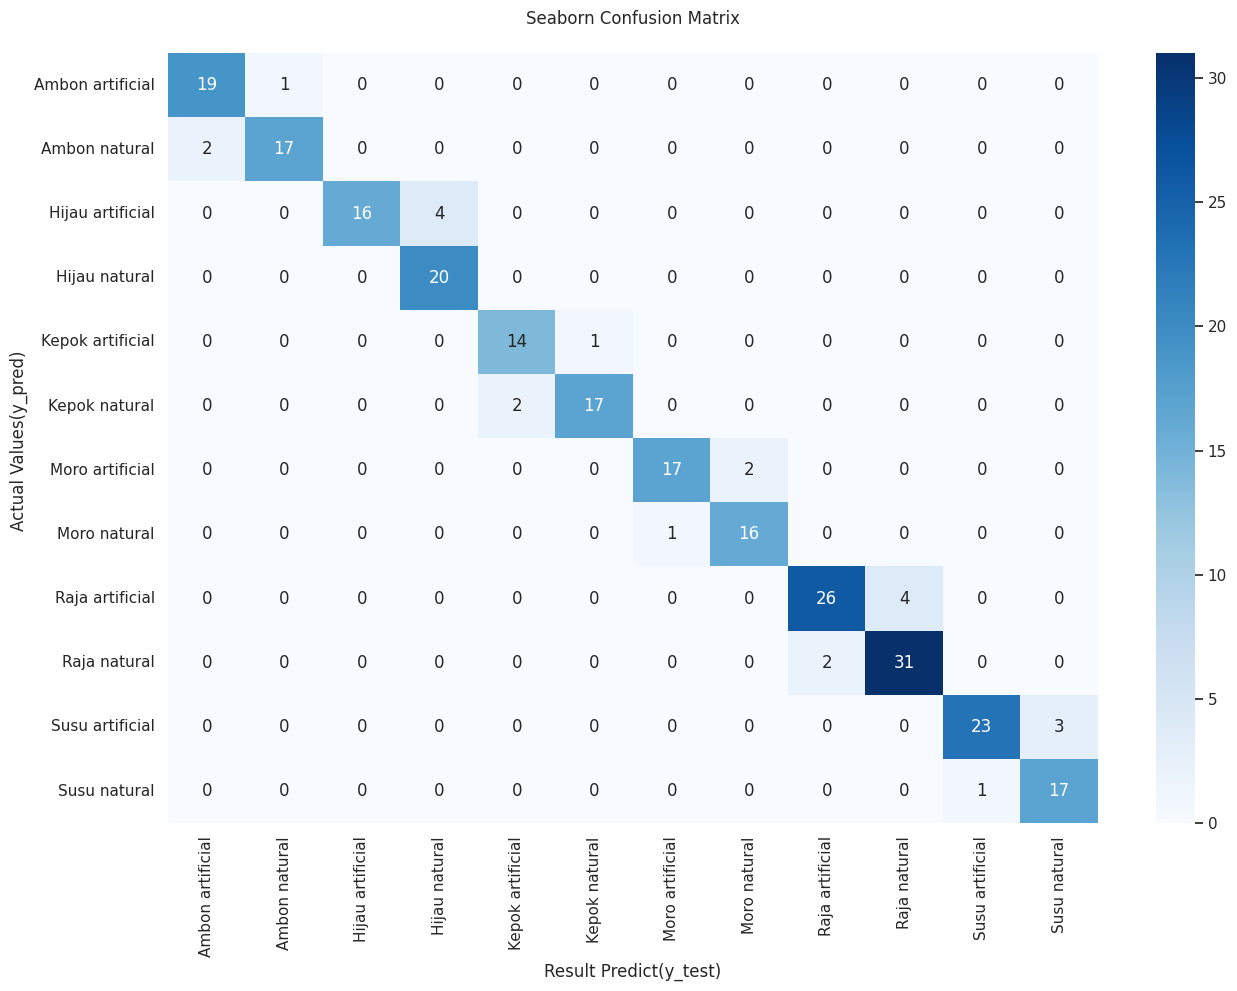

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Seaborn Confusion Matrix\n')
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ')

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.94      0.89      0.92        19
           2       1.00      0.80      0.89        20
           3       0.83      1.00      0.91        20
           4       0.88      0.93      0.90        15
           5       0.94      0.89      0.92        19
           6       0.94      0.89      0.92        19
           7       0.89      0.94      0.91        17
           8       0.93      0.87      0.90        30
           9       0.89      0.94      0.91        33
          10       0.96      0.88      0.92        26
          11       0.85      0.94      0.89        18

    accuracy                           0.91       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.91      0.91      0.91       256

